# Topic Modelling for Massachusetts

In [38]:
# Set tag so gensim doesn't throw an error
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Handle imports
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm_notebook as tqdm

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# Load data
df = pd.read_csv("Standardized Data/MA_Final_cleaned.csv")

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Text Cleaning and Preprocessing

In [42]:
# Manually updated list of stopwords
stop_word_list = [
   
    'applicable',
    'understands',
    'commissioner',
    'licensing',
    'regulation',
    'person',
    'engage',
    'general',
    'article',
    'organization',
    'secretary',
    'commonwealth',
    'commerce,'
    'commence',
    'abovecaptioned',
    'stipulate',
    'consent',
    'docket',
    'divisions',
    'massachusetts',
    'ma',
    'cmr',
    'bank',
    'federal',
    'mortgage',
    'division',
    'order',
    'chapter',
    'section',
    'state',
    'law',
    'date',
    'paragraph',
    'record',
    'sign',
    'act',
    'federal',
    'secure',
    'enforcement',
    'nmls',
    'finding',
    'fact',
    'page',
    'general',
    'standard',
    'warrant',
    'condition',
    'information',
    'time',
    'jurisdiction',
    'a',
    'b',
    'd',
    'e',
    'f',
    'g',
    'h',
    'i',
    'k',
    'c'
    'safe',
    'faqs',
    'faq',
    'notify',
    'intent',
    'party',
    'matter',
    'agree',
    'follow',
    'settlement',
    'agreement',
    'report',
    'recommendation',
    'administrative',
    'court',
    'remain',
    'effective',
    'immediately',
    'issuance',
    'provision',
    'warranty',
    'enforceable',
    'satisfy',
    'penalty',
    'pursuant',
    'dollar',
    'assess',
    'consideration',
    'set',
    'promise',
    'resolution',
    'representation',
    'aside',
    'competent',
    'include',
    'limit',
    'set',
    'promise',
    'resolution',
    'representation',
    'aside',
    'competent',
    'conclusion',
    'base',
    'far',
    'forth',
    'present',
    'sufficient',
    'temporary',
    'cease',
    'desist',
    'terminate',
    'application',
    'issue',
    'refuse',
    'revocation',
    'contain',
    'determine',
    'streamlined',
    'renewal',
    'process',
    'indicate',
    'statement',
    'corporation',
    'stipulation',
    'broker',
    'licensee',
    'applicant',
    'business',
    'lender',
    'corporate',
    'authorize',
    'regulatory'
    'amendment',
    'licensed',
    'statute',
    'entity',
    'surety',
    'findings',
    'facts',
    '255e'
]


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# Prepare Lemmatizers and Stop Words
nlp = spacy.load('en_core_web_lg')
lemmatizer = nlp.get_pipe("lemmatizer")
nlp.Defaults.stop_words.update(stop_word_list)
# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
lemma_tags = {"NNS", "NNPS"}


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Function to clean text
def clean_text(sample_text):
    sample_text = sample_text.translate(str.maketrans('', '', string.punctuation))
    sample_text = " ".join([w for w in sample_text.split() if not w.isdigit()])
    sample_text = sample_text.lower()
    doc = nlp(sample_text)
    doc = [token.lemma_ for token in doc if (token.tag_ in lemma_tags or token.lemma_ != '-PRON-' and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'])]
    doc = u' '.join(doc)
    doc = nlp.make_doc(doc)
    tokens = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return tokens

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
sample_text = df.loc[0,"Text"]
print(clean_text(sample_text))
print(len(clean_text(sample_text)))

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['relevant', 'organize', 'locate', 'accord', 'submit', 'maintain', 'file', 'license', 'require', 'hold', 'license', 'number', 'mb0624', 'expire', 'correspondence', 'consumer', 'collectively', 'borrower', 'request', 'borrower', 'complete', 'enclose', 'loan', 'residential', 'property', 'locate', 'provide', 'additional', 'borrower', 'review', 'copy', 'correspondence', 'receive', 'borrower', 'attach', 'exhibit', 'correspondence', 'current', 'rate', 'fix', 'term', 'currently', 'lock', 'letter', 'request', 'consumer', 'return', 'form', 'enclose', 'obtain', 'borrower', 'submit', 'complete', 'loan', 'additional', 'material', 'request', 'place', 'borrower', 'qualified', 'loan', 'term', 'correspondence', 'reference', 'define', 'compensation', 'gain', 'expectation', 'compensation', 'gain', 'directly', 'indirectly', 'negotiate', 'place', 'assist', 'placement', 'find', 'offer', 'negotiate', 'place', 'assist', 'placement', 'find', 'loan', 'residential', 'property', 'prohibit', 'activity', 'exempt', 

In [46]:
sample_text

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


", through the Commissioner, has jurisdiction over the licensing and regulation of persons engaged in the business of a mortgage broker pursuant to Massachusetts General Laws chapter 255E, section 2.  Mortgage One is, and at all relevant times has been, a corporation organized under the laws of the Commonwealth of Massachusetts. Mortgage One is located at 1408 Providence Highway, Norwood, Massachusetts, 02062, according to records submitted by Mortgage One and maintained on file with the Division.  Mortgage One is licensed by the Commissioner as a mortgage broker as required by General Laws chapter 255E, section 2. Mortgage One holds mortgage broker license number MB0624 which is set to expire on May 31, 2004.  On or about June 17, 2003, Mortgage One issued correspondence to two Massachusetts consumers, Andrew Klane and Suzanne Klane (collectively, the borrower), requesting that the borrower complete the enclosed mortgage loan application for a residential property located in Massachus

In [47]:
# Clean Text
text = df["Text"]
text_list = []
for doc in tqdm(text):
    if not pd.isna(doc):
        pr = clean_text(doc)
        text_list.append(pr)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-47-aa8e216ab7a6>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for doc in tqdm(text):


  0%|          | 0/323 [00:00<?, ?it/s]

In [48]:
# Store word_list in txt file for easier reference

with open('ma_text_list.txt','w',encoding='UTF-8') as file:
    file.writelines("%s\n" % text for text in text_list)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(text_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[text_list], threshold=30) 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
grammed_list = [trigram_mod[bigram_mod[doc]]for doc in text_list]
print(trigram_mod[bigram_mod[text_list[8]]])

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['mulberry', 'relevant', 'license', 'require', 'mulberry', 'initial', 'license', 'accord', 'maintain', 'file', 'mulberry', 'maintain', 'additional', 'location', 'conduct', 'accordance', 'mulberry', 'obtain', 'maintain', 'license', 'number', 'mb2508', 'respectively', 'additional', 'location', 'relevant', 'treasurer', 'director', 'principal', 'stockholder', 'mulberry', 'accord', 'annual', 'year', 'end', 'submit', 'mulberry', 'employ', 'mulberry', 'parttime', 'basis', 'grand_jury', 'impanel', 'district', 'return_indictment', 'individual', 'defendant', 'charge', 'sixtytwo', 'count', 'wire', 'fraud', 'count', 'conspiracy', 'launder', 'money', 'arise', 'participation', 'multimillion', 'fraud', 'scheme', 'individual', 'charge', 'grand_jury', 'indictment', 'charge', 'grand_jury', 'indictment', 'allege', 'defendant', 'participate', 'scheme', 'purchase', 'distressed', 'property', 'rapidly', 'resell', 'property', 'artificially', 'inflate', 'value', 'practice', 'generally', 'refer', 'land', 'flip'

## HDP Model to determine suitable range of choices for Topic Modelling

In [50]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(text_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in text_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
# Creates, which is a mapping of word IDs to words.
grammed_words = corpora.Dictionary(grammed_list)

# Turns each document into a bag of words.
grammed_corpus = [grammed_words.doc2bow(doc) for doc in grammed_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
import tomotopy as tp
import numpy as np

term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw = term_weight, min_cf =5, rm_top = 0, gamma = 1, alpha = 0.1,initial_k = 5, seed = 12)
sum = 0
for text in text_list:
    if len(text) > 0:
        hdp.add_doc(text)
print(sum)
# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs,
      ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)

# Train model
for i in range(0, 1000, 100):
    hdp.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
Num docs: 323 , Vocab size: 1300 , Num words: 95800
Removed top words: []
Iteration: 0	Log-likelihood: -5.599918610691278	Num. of topics: 16
Iteration: 100	Log-likelihood: -5.552002403191087	Num. of topics: 16
Iteration: 200	Log-likelihood: -5.536185371465126	Num. of topics: 17
Iteration: 300	Log-likelihood: -5.535655314056261	Num. of topics: 17
Iteration: 400	Log-likelihood: -5.532599500283319	Num. of topics: 17
Iteration: 500	Log-likelihood: -5.534472922659119	Num. of topics: 18
Iteration: 600	Log-likelihood: -5.534126981688441	Num. of topics: 18
Iteration: 700	Log-likelihood: -5.535116287683893	Num. of topics: 18
Iteration: 800	Log-likelihood: -5.534938968907817	Num. of topics: 18
Iteration: 900	Log-likelihood: -5.534545513834486	Num. of topics: 18


## LDA Topic Modelling

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = 12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=text_list, start=5, limit=25, step=1)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Can take a long time to run.
grammed_model_list, grammed_coherence_values = compute_coherence_values(dictionary=grammed_words, corpus=grammed_corpus, texts=grammed_list, start=5, limit=25, step=1)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
coherence_values

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.3385895484251361,
 0.34474704095593117,
 0.3486083722859896,
 0.34143152816464295,
 0.3425501018049437,
 0.33196197097276614,
 0.3496569585760079,
 0.33888958090402027,
 0.33686676822196865,
 0.34012929915274465,
 0.3301098013840379,
 0.3349617202958969,
 0.34114690231008243,
 0.3478965636771095,
 0.33147983535593784,
 0.33156184894025414,
 0.3300993306466099,
 0.3236187014411176,
 0.3186428964650205,
 0.31700618309490797]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


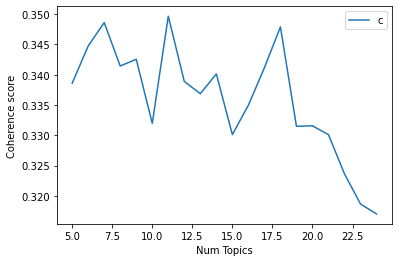

In [57]:
# Show graph
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
grammed_coherence_values

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.39966199261368124,
 0.377464402446892,
 0.36847072180802193,
 0.3694043565164262,
 0.35462274000174143,
 0.350484922265556,
 0.3374864777845446,
 0.3458983714724175,
 0.3510202783091507,
 0.3479666793554363,
 0.34964484489712555,
 0.35952056245021874,
 0.35463076713109354,
 0.34677339144862734,
 0.35112485534872756,
 0.3425143929899902,
 0.3420193084111825,
 0.3424496560113935,
 0.3176879482292219,
 0.33549830687804955]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


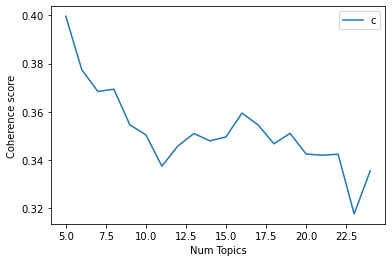

In [59]:
# Show graph
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, grammed_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [80]:
model_selected = grammed_model_list[11]
# Visualization of Categories

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(model_selected, grammed_corpus, grammed_words)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.085274  0.065805       1        1  21.021801
3      0.110062 -0.012426       2        1  19.444092
14    -0.041107 -0.064454       3        1  14.626312
6      0.028007 -0.061469       4        1   9.041197
2     -0.033104 -0.028587       5        1   7.250890
11    -0.028468 -0.022526       6        1   6.811399
1     -0.117945 -0.011063       7        1   5.102014
7      0.008791  0.031056       8        1   4.382745
8      0.030701  0.002351       9        1   3.928310
0     -0.065628 -0.034410      10        1   2.311566
10     0.048480  0.031694      11        1   1.723068
9      0.099002  0.017448      12        1   1.610818
5      0.064618 -0.032801      13        1   1.187949
13    -0.043491  0.021414      14        1   0.934325
4     -0.020794  0.062428      15        1   0.598340
12     0.046151  0.035540      16        1   0.025174, topic_info=                       Term         Freq        Total Category  logprob  \
29                     loan  3601.000000  3601.000000  Default  30.0000   
1894                   bond  1606.000000  1606.000000  Default  29.0000   
28                  license  2196.000000  2196.000000  Default  28.0000   
23                     file  1081.000000  1081.000000  Default  27.0000   
51                  require  1056.000000  1056.000000  Default  26.0000   
...                     ...          ...          ...      ...      ...   
85    examinationinspection     0.080041   584.892309  Topic16  -5.5207   
377                  income     0.081372   668.821843  Topic16  -5.5042   
121               violation     0.077862   606.790603  Topic16  -5.5483   
88                  failure     0.075303   528.535331  Topic16  -5.5817   
48                reference     0.070974   335.712005  Topic16  -5.6409   

      loglift  
29    30.0000  
1894  29.0000  
28    28.0000  
23    27.0000  
51    26.0000  
...       ...  
85    -0.6095  
377   -0.7271  
121   -0.6739  
88    -0.5692  
48    -0.1746  

[1222 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2291      1  0.620387  10day_comment
2291      3  0.099262  10day_comment
2291      5  0.049631  10day_comment
2291      6  0.037223  10day_comment
2291      7  0.099262  10day_comment
...     ...       ...            ...
420      11  0.016005           year
420      12  0.016005           year
420      13  0.010670           year
420      14  0.021341           year
420      15  0.010670           year

[3958 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 4, 15, 7, 3, 12, 2, 8, 9, 1, 11, 10, 6, 14, 5, 13])

In [61]:
# Visualization of Categories

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(model_selected, corpus, words)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.034175 -0.136788       1        1  25.893319
2     -0.233967  0.047998       2        1  16.697192
13     0.060311 -0.010767       3        1   9.438420
6     -0.001673  0.014289       4        1   8.743177
5     -0.024767  0.023014       5        1   8.479662
3      0.083464  0.049474       6        1   6.283182
11    -0.029851  0.008628       7        1   5.489506
12    -0.005690 -0.042316       8        1   4.876636
1      0.089201  0.020135       9        1   3.900781
10     0.082986  0.080578      10        1   3.769571
8      0.062880 -0.063549      11        1   2.154681
15    -0.089665 -0.052807      12        1   1.089716
14     0.034376 -0.049192      13        1   1.041531
7     -0.010691  0.064700      14        1   0.641783
0     -0.070920  0.004814      15        1   0.569663
9      0.079776  0.064720      16        1   0.541437
4     -0.059943 -0.022932      17        1   0.389743, topic_info=             Term         Freq        Total Category  logprob  loglift
1700         bond  2175.000000  2175.000000  Default  30.0000  30.0000
34           loan  2969.000000  2969.000000  Default  29.0000  29.0000
33        license  2479.000000  2479.000000  Default  28.0000  28.0000
618    originator  1651.000000  1651.000000  Default  27.0000  27.0000
700   requirement  1594.000000  1594.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
671   instruction     2.325786   769.279726  Topic17  -5.1028  -0.2540
313      original     1.893735   450.209684  Topic17  -5.3083   0.0763
77     compliance     1.895622   559.719402  Topic17  -5.3073  -0.1405
760          send     1.816055   503.615543  Topic17  -5.3502  -0.0777
545        public     1.692886   548.184114  Topic17  -5.4204  -0.2327

[1269 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1432      1  0.350766      1001a
2077      5  0.457321  2009040co
1157      1  0.265764       27th
1157      4  0.265764       27th
1305      5  0.269377        2nd
...     ...       ...        ...
423      14  0.002222       year
423      15  0.004444       year
423      16  0.002222       year
423      17  0.002222       year
2007      6  0.356241  â§â§1016e

[4388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 3, 14, 7, 6, 4, 12, 13, 2, 11, 9, 16, 15, 8, 1, 10, 5])

In [62]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
def format_topics_sentences(ldamodel=model_selected, corpus=corpus, texts=text_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model_selected, corpus=grammed_corpus, texts=grammed_list)
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.head()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

df_dominant_topics.sort_values(by = ["Num_Documents"],ascending = False, inplace = True)
df_dominant_topics["Old Index"] = df_dominant_topics.index 
df_dominant_topics.reset_index(inplace = True)
mapping = df_dominant_topics[["Old Index"]].to_dict()['Old Index']
mapping = {value : key+1 for (key, value) in mapping.items()}
mapping

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{15.0: 1,
 14.0: 2,
 0.0: 3,
 2.0: 4,
 6.0: 5,
 3.0: 6,
 11.0: 7,
 8.0: 8,
 7.0: 9,
 1.0: 10,
 4.0: 11,
 9.0: 12,
 10.0: 13,
 5.0: 14,
 13.0: 15}

In [82]:
df_topic_sents_keywords["Dominant_Topic"] = df_topic_sents_keywords["Dominant_Topic"].apply(lambda x: mapping[x])

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show topics per text
df_dominant_topic

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.6905,"loan, license, originator, require, requirement, bond, file, obtain, submit, provide","[relevant, organize, locate, accord, submit, maintain, file, license, require, hold, license, number, mb0624, expire, correspondence, consumer, collectively, borrower, request, borrower, complete, enclose, loan, residential, property, locate, provide, additional, borrower, review, copy, correspondence, receive, borrower, attach_exhibit, correspondence, current, rate, fix, term, currently, lock, letter, request, consumer, return, form, enclose, obtain, borrower, submit, complete, loan, additional, material, request, place, borrower, qualified, loan, term, correspondence, reference, define, compensation_gain, expectation, compensation_gain, directly_indirectly, negotiate_place, assist_placement_find, offer, negotiate_place, assist_placement_find, loan, residential, property, prohibit, activity, exempt, obtain, license, define, activity, enter, rate_lock_commitment, exclusive, authority, residential, loan, transaction]"
1,1,7,0.9326,"loan, license, originator, bond, fail, requirement, provide, require, safe, obtain","[platinum_capital, relevant, organize, platinum_capital, locate, locate, branch, location, locate, accord, submit, platinum_capital, maintain, file, platinum_capital, license, require, platinum, capitalapos, initial, license, platinum_capital, grant, branch, license, conduct, loan, activity, hold, license, number, mc0958, mc3142, expire, duly, examiner, performance, official, duty, attempt, conduct, inspection, platinum, book, account, file, management, employee, fail, provide, immediate, access, corporationaposs, book, examiner, failure, acquire, license, prior, conduct, loan, activity, platinum_capital, submit, obtain, branch, license, capital, approve, conduct, grant, access, book, divisionaposs, examiner, conduct, inspection, location, book, review, field, examiner, platinum_capital, accept_early, platinum, branch, pipeline, submit, subsequent, visitation, loan, accept, platinum_capital, early, branch, pipeline, loan, accept, platinum_capital, prior, ...]"
2,2,7,0.9308,"loan, license, originator, bond, fail, requirement, provide, require, safe, obtain","[activity, receive, license, march, file, approve, manager, file, officer, commence, accept, loan, loan, lead, primarily, internet, site, lead, subsequent, loan, identify, loan, employer, approve, branch, pipeline, provide, platinum_capital, group, accept, credit, approval, management, early, numerous, loan, identify, intervieweraposs, employer, approve, novastar, numerous, disclosure, identify, receive, approve, license, reference, letter, march, serge, identify, owner, address, novastar, previously, approve, license, novastar, main, serve, bevil, manager, financial, branch, locate, address, continue, disclosure, identify, novastar, identify, platinum_capital, group, loan, close, numerous, fee, pay, management, platinum, approval, open, branch, office, deny, license, fail, pay, investigation, fee, fail, respond, request, additional, branch, location, platinum, group, receive, ...]"
3,3,3,0.9886,"loan, license, originator, bond, requirement, obtain, fail, maintain, conduct, require","[instaficom, relevant, organize, locate, accord, submit, instaficom, maintain, file, instaficom, license, require, hold, license, number, mc2158, mc3119, expire, receive, copy, internet, news, instaficom, comment, offer, representative, instaficomaposs, management, confirm, instaficom, operation, reduce, staff, retain, dissolve, internet, news, pende, initially, accept, instaficom, transfer, californiabase, company, similarly, license, representative, course, official, duty, able, confirm, representative, reference, approximately, loan, receive, instaficom, relate, residential, property, locate, receive, instaficom, write, verbal, notification, instaficom, intend, close, location, maintain, instaficom, receive, instaficom, wr

In [84]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9959,"bond, license, require, requirement, maintain, loan, obtain, file, fail, provide","[loans, loan, originator, nfs, loan, relevant, license, demonstrate, maintain, bond, form, approve, bond, clause_insurance_company, day, prior_cancel, bond_reason_automatically, suspend, license, cancellation_effect_bond, replace_renew, license, demonstrate, maintain, bond, sum_aggregate, loan, event_sum, bond, maximum, provide, sum, bond, increase_maximum, necessary, bond, clause_insurance_company, day, prior_cancel, bond_reason_automatically, suspend, license, cancellation_effect_bond, replace_renew_amendment, 42032a, public_hearing, hold, purpose, afford, loans, interested_opportunity, provide, oral_written_testimony, regard_propose, amendment, bond, requirement, public_hearing, 10day_comment, period, open_finalization_amendment, industry_letter_distribute, provide, advance_notice, substantial_revision_necessity, obtain, bond, license, 7th, require, comply_new, net_worth_bond, requirement, conduct, obtain, bond, violation_cite_consider, failure, obtain, bond, violation, regulatory_bulletin, bond, requirement, obtain, hold, license, establish, maintain, bond, duration, bond, continuous_bonding, company, insurance, company, regulatory_bulletin, bond, requirement, 42032a2, ...]"
1,2,0.9976,"loan, originator, license, safe, requirement, bond, maintain, fail, submit, violation","[activity, loan, originator, lore, relevant, license, loan, originator, adopt_fair, lore, amend_govern, loan, originator, bring_compliance, fair, safe, amendment_255f_mandate, loan, originator, license, comply, certain_revise, requirement, completion, mininum, hour_prelicense, education, approve, nationwide_system, achievement_pass, score, define_seventyfive_percent_correct, write, safe, loan, originator, test_develop, c_submission_fingerprint, investigation_criminal, history_background, check_collectively, safe, requirement, loan, originator, license, apply_grant, safe, requirement, ensure, compliance, revise, govern, loan, originator, ensure_compliant_amend, implement_testing, requirement, reference_41042f, license, lore, require, achieve_pass, score, define, national_component, write, safe, loan, originator, test_develop, initially, reference, safe, requirement, correspond_compliance, timing_deadline, industry_letter_publish, website_link_relevant, portion_website, series_frequently_ask_question, describe, safe, requirement, provide, notice, disclosure_currently, license, loan, originator, meet, requirement, licensure_deadline, unable, approve, loan, originator, continued_licensure_instruction, regard, license, ...]"
2,3,0.9886,"loan, license, originator, bond, requirement, obtain, fail, maintain, conduct, require","[instaficom, relevant, organize, locate, accord, submit, instaficom, maintain, file, instaficom, license, require, hold, license, number, mc2158, mc3119, expire, receive, copy, internet, news, instaficom, comment, offer, representative, instaficomaposs, management, confirm, instaficom, operation, reduce, staff, retain, dissolve, internet, news, pende, initially, accept, instaficom, transfer, californiabase, company, similarly, license, representative, course, official, duty, able, confirm, representative, reference, approximately, loan, receive, instaficom, relate, residential, property, locate, receive, instaficom, write, verbal, notification, instaficom, intend, close, location, maintain, instaficom, receive, instaficom, write, verbal, notification, change, officer_director, instaficom]"
3,4,0.9966,"loan, license, originator, require, requirement, bond, file, obtain, submit, provide","[loan, originator, capital, relevant, company, conduct, capital, main_office, locate, locate, relevant, sole, member, capital, capital, license, accord, maintain, file, initially, license, license, number, capital, license, capital, conduct, company, main_office, locate, license, loan, originator, accord, initially, loan

In [85]:
df_with_text = df[df["Text Length"] > 0]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
df_with_text.reset_index(inplace =True)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
df_without_text = df[df["Text Length"]==0]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
df_without_text.reset_index(inplace = True)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
final_df = pd.concat([df_with_text,df_dominant_topic],axis = 1)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
final_df.columns

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['index', 'Unnamed: 0', 'City, State', 'Date', 'Enforcement Action',
       'Entity Name', 'Entity Type', 'Found', 'Processed?', 'State Enforcing',
       'Text', 'Text Length', 'New Length', 'Percentage', 'Document_No',
       'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text'],
      dtype='object')

In [91]:
final_df.drop(["index","Unnamed: 0","Found","Processed?","Document_No","Keywords"],axis=1,inplace= True)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
final_df.columns = ['City, State', 'Date', 'Enforcement Action', 'Entity Name',
       'Entity Type', 'State Enforcing', 'Text', 'Text Length', 'New Length',
       'Percentage', 'Dominant Topic', 'Topic Confidence', 'Cleaned Text']

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
final_df[final_df["Dominant Topic"]==15]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


City, State        Date                Enforcement Action  \
160  Randolph, MA  06/22/2009  MULTI-STATE SETTLEMENT AGREEMENT   

                       Entity Name      Entity Type State Enforcing  \
160  TAYLOR, BEAN & WHITAKER CORP.  MORTGAGE LENDER              MA   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [94]:
final_df = pd.concat([final_df,df_without_text],axis=0,ignore_index = True)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
final_df.shape

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(323, 17)

In [96]:
final_df.drop(["index","Unnamed: 0","Found","Processed?"],axis=1,inplace=True)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_mapping = {
    1: "Failure to meet regulatory standards",
    2: "Did not pass NMLS test",
    3: "Administrative Penalty or Criminal Past",
    4: "Administrative Penalty or Failure to meet regulatory standards",
    5: "Substantial non-compliance/Operating without a license",
    6: "Criminal",
    7: "deceptive practices",
    8: "Administrative",
    9: "Failure to comply with regulations",
    10: "Administrative/Surety Bond",
    11: "violations of civil law",
    12: "Administrative/Deception",
    13: "criminal",
    14: "deception",
    15: "Failure to meet regulatory standards",
}

In [ ]:
topic_mapping = {
    1: "Administrative",
    2: "Administrative",
    3: "Mixed",
    4: "Administrative",
    5: "Administrative",
    6: "Criminal Activity",
    7: "Criminal Activity",
    8: "Administrative",
    9: "Administrative",
    10: "Administrative",
    11: "Criminal Activity",
    12: "Mixed",
    13: "Criminal Activity",
    14: "Criminal Activity",
    15: "Administrativ",
}